In [20]:
from PIL import Image
import glob
import torch.utils.data as data
from tqdm.notebook import trange, tqdm

class ImageNetLimited(data.Dataset):
    """ImageNet Limited dataset."""
    
    def __init__(self, root_dir, transform=None):
        
        if transform:
            self.transform = transform

        files = glob.glob(root_dir+'/[0-9]/*.png')

        self.images=[]
        self.labels=[]
        
        for file in tqdm(files):
            temp = Image.open(file).convert("RGB")
            keep = temp.copy()
            self.labels.append(int(file.split('/')[-2]))
            self.images.append(keep)
            temp.close()

    def __len__(self):
    
        return len(self.images)

    def __getitem__(self, idx):

        label = self.labels[idx]
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        return image,label


In [22]:
from torchvision.transforms import ToTensor, Normalize, Compose

train_dir='data/train'
validation_dir='data/val'

transform = Compose([ToTensor(), # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                    Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                    ])

train_set = ImageNetLimited(train_dir,transform=transform)
validation_set = ImageNetLimited(validation_dir,transform=transform)

In [52]:
import torch.nn as nn


class Flatten(nn.Module):
    """
    Flatten a convolution block into a simple vector.

    Replaces the flattening line (view) often found into forward() methods of networks. This makes it
    easier to navigate the network with introspection
    """
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x


class PR_CNN(nn.Module):
    """
    Simple feed forward convolutional neural network

    Attributes
    ----------
    expected_input_size : tuple(int,int)
        Expected input size (width, height)
    conv1 : torch.nn.Sequential
    conv2 : torch.nn.Sequential
    conv3 : torch.nn.Sequential
        Convolutional layers of the network
    fc : torch.nn.Linear
        Final classification fully connected layer

    """

    def __init__(self, **kwargs):
        """
        Creates an CNN_basic model from the scratch.

        Parameters
        ----------
        output_channels : int
            Number of neurons in the last layer
        input_channels : int
            Dimensionality of the input, typically 3 for RGB
        """
        super(PR_CNN, self).__init__()

        # PR_FILL_HERE: Here you have to put the expected input size in terms of width and height of your input image
        self.expected_input_size = (28, 28)

        # First layer
        self.conv = nn.Sequential(
            # PR_FILL_HERE: Here you have to put the input channels, output channels ands the kernel size
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=3),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=3),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=3),
            nn.LeakyReLU()
        )


        # Classification layer
        self.fc = nn.Sequential(
            Flatten(),
            # PR_FILL_HERE: Here you have to put the output size of the linear layer. DO NOT change 1536!
            nn.Linear(128, 10)
        )

    def forward(self, x):
        """
        Computes forward pass on the network

        Parameters
        ----------
        x : Variable
            Sample to run forward pass on. (input to the model)

        Returns
        -------
        Variable
            Activations of the fully connected layer
        """
        x = self.conv(x)
        x = self.fc(x)
        return x


In [53]:
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange, tqdm
import numpy as np

def train_epoch(model, train_dataloader, optimizer, loss_fn):
    losses = []
    correct_predictions = 0

    # Iterate mini batches over training dataset
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        # Run predictions
        output = model(images)
        # Set gradients to zero
        optimizer.zero_grad()
        # Compute loss
        loss = loss_fn(output, labels)
        # Backpropagate (compute gradients)
        loss.backward()
        # Make an optimization step (update parameters)
        optimizer.step()
        # Log metrics
        losses.append(loss.item())
        predicted_labels = output.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
    # Return loss values for each iteration and accuracy
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(train_dataloader.dataset)
    return mean_loss, accuracy

def evaluate(model, dataloader, loss_fn):
    losses = []
    correct_predictions = 0
    # Iterate mini batches over validation dataset
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Run predictions
            output = model(images)
            # Compute loss
            loss = loss_fn(output, labels)
            # Save metrics
            losses.append(loss.item())
            predicted_labels = output.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
    # Return mean loss and accuracy
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(dataloader.dataset)
    return mean_loss, accuracy

def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Run training for n_epochs
    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    return train_losses, val_losses, train_accuracies, val_accuracies


In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_conv = PR_CNN()
model_conv = model_conv.to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model_conv.parameters(), lr=learning_rate)
n_epochs = 10
loss_fn = nn.CrossEntropyLoss()

batch_size = 32

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8,pin_memory=True)
val_dataloader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=8,pin_memory=True)

train_losses, val_losses, train_accuracies, val_accuracies = train(model_conv, train_dataloader, val_dataloader, optimizer, n_epochs=n_epochs, loss_function=loss_fn)




Epoch 1/10: train_loss: 0.2762, train_accuracy: 91.6716, val_loss: 0.1082, val_accuracy: 96.7879



Epoch 2/10: train_loss: 0.0904, train_accuracy: 97.3333, val_loss: 0.0843, val_accuracy: 97.4646



Epoch 3/10: train_loss: 0.0625, train_accuracy: 97.9925, val_loss: 0.0821, val_accuracy: 97.5202



Epoch 4/10: train_loss: 0.0452, train_accuracy: 98.6070, val_loss: 0.0778, val_accuracy: 97.7677



Epoch 5/10: train_loss: 0.0346, train_accuracy: 98.8607, val_loss: 0.0758, val_accuracy: 97.7929



Epoch 6/10: train_loss: 0.0267, train_accuracy: 99.1393, val_loss: 0.0817, val_accuracy: 97.6970



Epoch 7/10: train_loss: 0.0224, train_accuracy: 99.2413, val_loss: 0.0756, val_accuracy: 97.9343



Epoch 8/10: train_loss: 0.0170, train_accuracy: 99.4254, val_loss: 0.0943, val_accuracy: 97.9141



Epoch 9/10: train_loss: 0.0161, train_accuracy: 99.4602, val_loss: 0.0893, val_accuracy: 97.9495



Epoch 10/10: train_loss: 0.0127, train_accuracy: 99.5995, val_loss: 0.0966, val_accuracy: 97.9192


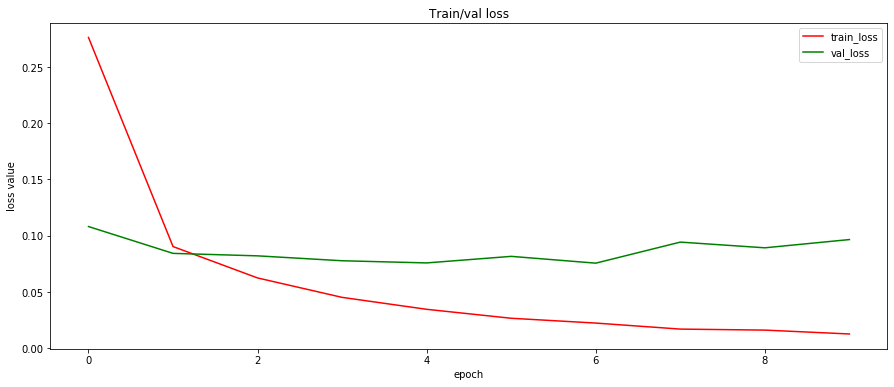

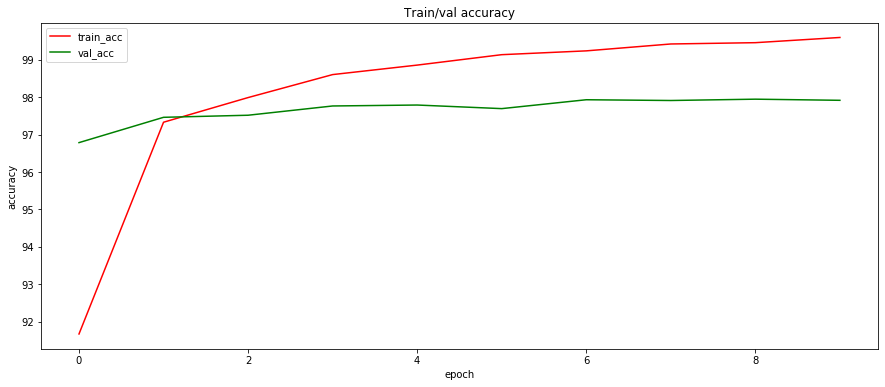

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(15,6))
    
    legend_loss=[]

    plt.plot(np.arange(n_epochs), train_losses,'r')
    legend_loss.append('train_loss')

    plt.plot(np.arange(n_epochs), val_losses,'g')
    legend_loss.append('val_loss')
        
    plt.legend(legend_loss)
    
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    plt.title('Train/val loss');

    plt.figure(figsize=(15,6))
    
    legend_acc=[]

    plt.plot(np.arange(n_epochs), train_accuracies,'r')
    legend_acc.append('train_acc')

    plt.plot(np.arange(n_epochs),val_accuracies, 'g')
    legend_acc.append('val_acc')

    plt.legend(legend_acc)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Train/val accuracy');

plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies)
